# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [7]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

ValueError: Expected object or value

In [ ]:
def clean_portfolio(df=portfolio):
    '''
    Description: cleaning protfolio datafram to OneHotEncoding(dummy variables)
    Input: portfolio
    Output: the cleaned portfolio
    '''
    # duration days -> hours, consistent with transcript
    portfolio_new = portfolio.copy()
    portfolio_new['duration'] = portfolio['duration']*24
    # rename id -> offer_id
    portfolio_new.rename(columns={'id':'offer_id'}, inplace = True)
    
    # get dummies to channel and offer_type
    channels = portfolio['channels'].apply(lambda x: ','.join(x))
    channels = pd.Series(channels).str.get_dummies(',')
    
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # new cleaned portfolio
    portfolio_new = pd.concat([channels, portfolio_new[['difficulty', 'duration', 'offer_id', 'reward']], offer_type], axis=1, sort=False)
    
    return portfolio_new  

In [ ]:
portfolio_new = clean_portfolio()
portfolio_new.head()

In [ ]:
sns.distplot(profile['age'], kde=False)

In [ ]:
def clean_profile(df=profile):
    #from sklearn.impute import SimpleImputer
    '''
    Description: cleaning profile dataframe
    Input: profile 
    Output: cleaned profile
    Features: [gender,age,id,became_member_on,income]
    '''

    # # age 118 makes no sense, replace 118 with unknown number
    # profile['age'].replace(118, np.nan,inplace=True)

    # drop 2175 nan
    profile_new = profile.dropna()

    # # gender: assign unknown to other
    # profile['gender'].replace('None', 'O', inplace=True)
    # get dummies to gender
    gender = pd.get_dummies(profile_new['gender'])

    # # impute with mean
    # imp_age, imp_income = SimpleImputer(missing_values=np.nan, strategy='mean'), \
    #     SimpleImputer(missing_values=np.nan, strategy='mean')
    # imp_age.fit(profile[['age']])
    # age = pd.DataFrame(imp_age.transform(profile[['age']]))

    # imp_income.fit(profile[['income']])
    # income = pd.DataFrame(imp_income.transform(profile[['income']]), columns={'income'})

    # get dummies to age
    #age_bins = pd.cut(age.to_numpy()[:,0], bins=range(10,110,10), labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s'])
    age_bins = pd.cut(profile_new['age'], bins=range(10,110,10), labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s'])
    age_cat = pd.get_dummies(age_bins)

    # datetime to become_member_on
    member_date = pd.to_datetime(profile_new['became_member_on'],format='%Y%m%d')
    member_year = pd.get_dummies(member_date.dt.year,prefix='year', prefix_sep='_')
    member_month = pd.get_dummies(member_date.dt.month,prefix='month', prefix_sep='_')


    profile_new = pd.concat([gender,age_cat,profile_new['id'],member_year,member_month,profile_new['income']], axis=1)
    

    return profile_new

In [6]:
profile_new =clean_profile()
profile_new.head()

NameError: name 'clean_profile' is not defined

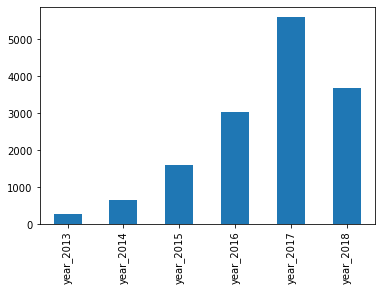

In [7]:
profile_new.loc[:,'year_2013':'year_2018'].sum().plot.bar()

There are many new member enrolled in year 2017 and 2018.

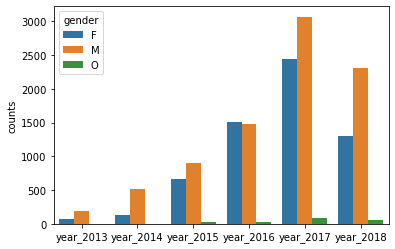

In [8]:
gender_year = pd.concat([profile['gender'].dropna(), profile_new.loc[:,'year_2013':'year_2018']],axis=1)
x = pd.DataFrame(gender_year.groupby('gender').sum().unstack(), columns={'counts'})
sns.barplot(x = x.index.get_level_values(0), y = x['counts'],hue = x.index.get_level_values(1),data = x)

Generally, there are more male became members every year. Especially in 2018.

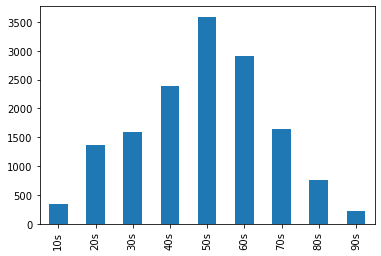

In [9]:
profile_new.loc[:,'10s':'90s'].sum().plot.bar()

The member age mostly distributes from 30s to 70s.

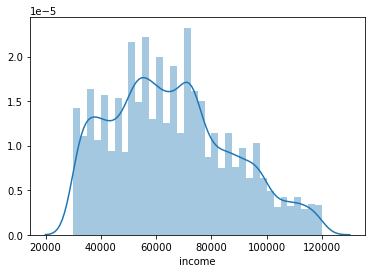

In [10]:
sns.distplot(profile_new['income'])

Members income distributes kind of normal with mean of 60000.

In [8]:
def clean_transcript(transcript, portfolio):
    """
    Description: cleaning transcript dataframe
    Input: transcript 
    Output: cleaned transcript
    Features: [gender,age,id,became_member_on,income]
    """
    # rename person_id to id
    transcript_new = transcript.rename(columns={'person':'id'})
    # remove the person who age 118 (those data points were removed)
    age_118_label = profile[profile['age'] == 118]['id']
    transcript_new = transcript_new[~transcript_new['id'].isin(age_118_label)]
    
    df_offer = transcript_new[transcript_new['event'].isin(['offer received', 'offer viewed', 'offer completed'])].reset_index()

    o_ids = []
    o_types = []
    for i in range(len(df_offer)):
        if df_offer.iloc[i]['event'] == 'offer completed':
            o_id = df_offer.iloc[i]['value']['offer_id']
        else:
            o_id = df_offer.iloc[i]['value']['offer id']
        o_ids.append(o_id)
        o_types.append(portfolio[portfolio['id'] == o_id]['offer_type'].values[0])
    
    df_offer['offer_id'] = pd.Series(o_ids)
    df_offer['offer_type'] = pd.Series(o_types)

    event_cat = pd.get_dummies(df_offer['event'])
    df_offer = pd.concat([df_offer, event_cat], axis=1)
    

    df_transaction = transcript_new[transcript_new['event'] == 'transaction'].reset_index()
    df_transaction['amount'] = df_transaction['value'].apply(lambda x:x['amount'])

    df_offer = df_offer.drop(['value', 'event'], axis = 1)
    df_transaction = df_transaction.drop(['value', 'event'], axis =1)
    return transcript_new, df_offer, df_transaction


In [9]:
transcript_new, df_offer, df_transaction = clean_transcript(transcript, portfolio)

In [10]:
def combine_offer_transaction(df_offer, df_transaction):
    """
    Description: merge offer and transcation together
    """
    df_transaction.sort_values(by=['id', 'time'], inplace=True)
    df_transaction['cum'] = df_transaction['amount'].cumsum()
    total_spend = pd.DataFrame(df_transaction.groupby(by='id')['cum'].max()).rename(columns={'cum':'total'}).reset_index()
    df_transaction = pd.merge(df_transaction, total_spend, how='left')
    
    df_offer.sort_values(by=['id', 'time'], inplace =True)
    
    df_merge = pd.merge(df_offer, df_transaction, how='outer').sort_values(by=['id','time'])
    df_merge['cum'].fillna(method='ffill', inplace = True)
    df_merge['total'].fillna(method='ffill', inplace = True)
    
    df_merge.dropna(subset=['offer_id'], inplace=True)
    df_merge.drop('index', axis =1, inplace=True)
    return df_merge
df_merge = combine_offer_transaction(df_offer, df_transaction)

Question: Which population's purchase is motivated by offer? Which of them would make purchase in any way?

In [11]:
# merge three df all together (profile, portfolio and offer_transcation) to get master sheet
df_master = pd.merge(df_merge, profile_new, on ='id')
df_master = pd.merge(df_master, portfolio_new, how ='left')
df_master.head()

,id,time,offer_id,offer_type,offer completed,offer received,offer viewed,amount,cum,total,...,email,mobile,social,web,difficulty,duration,reward,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,1.0,0.0,NaN,NaN,NaN,...,1,1,1,0,0,72,0,0,0,1
1,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,informational,0.0,0.0,1.0,NaN,NaN,NaN,...,1,1,1,0,0,72,0,0,0,1
2,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,informational,0.0,1.0,0.0,NaN,22.16,127.6,...,1,1,0,1,0,96,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,informational,0.0,0.0,1.0,NaN,22.16,127.6,...,1,1,0,1,0,96,0,0,0,1
4,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0.0,1.0,0.0,NaN,22.16,127.6,...,1,1,1,1,5,120,5,1,0,0


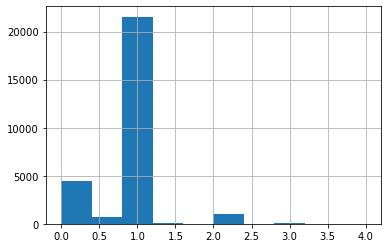

In [14]:
# view how many completed offer is viewed by members
df= pd.concat([df_master[['id', 'offer_id', 'offer_type']], df_master.loc[:,'cum':]], axis=1)
df= pd.merge(x, df.drop_duplicates(subset=['id', 'offer_id']), how ='left')
df_new= df_master_2[df_master_2['offer completed'] > 0]
view_complete_ratio = (df_new['offer viewed'] / df_new['offer completed'])
view_complete_ratio.hist()

In [16]:
# label the data enteries in which view_complete ratio >= 1 with 1, because this purchase may be promoted by the offer
# label the data enteries in which view_complete ratio < 1 with 0, because this purchase would be made in any way
view_complete_ratio['offer_label'] = (df['offer viewed'] / df['offer completed']).apply(lambda x:1 if x >= 1 else 0)
df['offer_label'].groupby(by = df['offer_label']).count()

offer_label
0     5173
1    22769
Name: offer_label, dtype: int64

5173 labelled with 0 (no offer stimulus), 22769 lablled with 1 (offer stimulus)

In [21]:
def data_preprocess(df=df):
    """
    Description: data preprocess
    """
    # remove ['offer_type', 'id', 'offer_id', 'offer completed', 'offer received', 'offer viewed'] columns
    df_new = df.drop(['offer_type', 'id', 'offer_id', 'offer completed', 'offer received', 'offer viewed'],axis =1) 
    scaler = MinMaxScaler()
    df_norm = scaler.fit_transform(df_new[['cum', 'total', 'income', 'difficulty', 'duration', 'reward']])
    df_new[['cum', 'total', 'income', 'difficulty', 'duration', 'reward']] = df_norm

    x, y  = df_new.drop(['offer_label'], axis=1), df_new['offer_label']
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=20)
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = data_preprocess()

In [22]:
def bulid_model(clf, param_grid, x=x_train, y=y_train):
    # cv uses StratifiedKFold
    # scoring f1 available as parameter

    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, refit=True)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(x, y)
    
    print("Best f1 : {}".format(round(grid.best_score_,4)))
    
    return grid.best_score_, grid.best_estimator_


rfc, gbc, abc, svc, knn = RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), svm.SVC(random_state=42), KNeighborsClassifier()



def sweep_model(clfs=[rfc, abc, gbc, svc, knn]):
    """
    Using different classification method
    """
    clf_names, clf_scores, clf_best_ests = [], [], []
    for clf in clfs:
        best_score, best_est = bulid_model(clf, {})
        clf_names.append(clf.__class__.__name__)
        clf_scores.append(best_score)
        clf_best_ests.append(best_est)
    return clf_names, clf_scores, clf_best_ests

clf_names, clf_scores, clf_best_ests = sweep_model()

Training RandomForestClassifier :
Best f1 : 0.8955
Training AdaBoostClassifier :
Best f1 : 0.9018
Training GradientBoostingClassifier :
Best f1 : 0.9041
Training SVC :
Best f1 : 0.8992
Training KNeighborsClassifier :
Best f1 : 0.891


In [52]:
def fit_model(clf):
    """
    Adjust the hyper-parameter
    """
    min_sample_split_range = [None, 2,5,10] #min sample split to be tested
    max_depth_range = [None, 1, 2, 5]  #max depth to be tested
    min_samples_leaf_range = [1, 2, 5] #min samples in the leaf to be tested
    min_leaf_nodes_range = [None, 5, 10, 20]    #min leaf nodes to be tested
    # n_estimators_range = [50, 100, 150]
    # learning_rate_range = [0.1, 0.2, 0.5, 1]
    parameters = {"min_samples_split": min_sample_split_range,
                "max_depth": max_depth_range,
                "min_samples_leaf": min_samples_leaf_range,
                "max_leaf_nodes": min_leaf_nodes_range,
                "n_estimators":n_estimators_range,
                "learning_rate":learning_rate_range 
                    }
    grid = GridSearchCV(estimator =clf, param_grid=parameters, cv=5, scoring ='f1')
    grid_model = make_pipeline(grid)
    grid_model.fit(x_train, y_train) 

    print("Accuracy of the tuned model: %.4f" %grid.best_score_)
    print(grid.best_params_)
    return grid_model
grid_model = fit_model(gbc)

[[ 641 1147]
 [ 415 7577]]


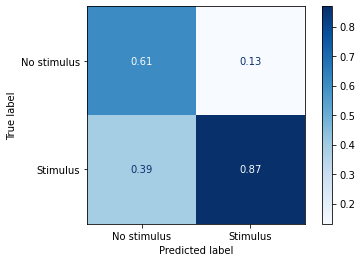

In [27]:
# result visulization
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
y_pred = grid_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(grid_model, x_test, y_test, display_labels=['No stimulus','Stimulus'],cmap=plt.cm.Blues,normalize='pred')
plt.show()


In [ ]:
feature_imp = pd.DataFrame(grid_model.feature_importances_,index=list(x_train.columns),columns=['feat_imp']).reset_index()
feature_imp.rename(columns={'index': 'feature'}, inplace=True)
feature_imp['feat_imp_rate'] = np.round((feature_imp['feat_imp']/feature_imp['feat_imp'].sum())*100,2)
feature_imp = feature_imp.sort_values(by=['feat_imp_rate'], ascending=False).reset_index(drop=True)
feature_imp.drop(columns=['feat_imp'],inplace=True)
feature_imp

In [40]:
# weight the imblance the data by repeat label-0 3 times (ratio(0:1) = 1/4)
def data_preprocess2(df=df):
    # remove ['offer_type', 'id', 'offer_id', 'offer completed', 'offer received', 'offer viewed'] columns
    df_new = df.drop(['offer_type', 'id', 'offer_id', 'offer completed', 'offer received', 'offer viewed'],axis =1) 
    df_new_fill = df_new[df_new['offer_label'] == 0]
    df_new = pd.concat([df_new, df_new_fill, df_new_fill, df_new_fill], axis=0).reset_index()

    scaler = MinMaxScaler()
    df_norm = scaler.fit_transform(df_new[['cum', 'total', 'income', 'difficulty', 'duration', 'reward']])
    df_new[['cum', 'total', 'income', 'difficulty', 'duration', 'reward']] = df_norm

    x, y  = df_new.drop(['offer_label'], axis=1), df_new['offer_label']
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=20)
    return x_train, x_test, y_train, y_test
x_train2, x_test2, y_train2, y_test2 = data_preprocess2()

In [ ]:
y_pred = gbc.predict(x_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(gbc, x_test, y_test, display_labels=['No stimulus','Stimulus'],cmap=plt.cm.Blues,normalize='pred')
plt.show()